<a href="https://colab.research.google.com/github/kushv16/Audio-Sentiment-Analysis/blob/master/CNN_3_Layer_%7C_2D_MFCC_features_%7C_Combined_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# import libraries
import pandas as pd
import numpy as np
import librosa
import librosa.display
import random
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  

In [4]:
df = pd.read_csv('/content/drive/MyDrive/LY Project/Result and Analysis/CNN Results | 2D MFCCs | Combined Data/combo_with_30_mfccs.csv')

In [5]:
df.sample()

,Unnamed: 0,path,filename,dataset,duration,sample_rate,gender,age,emotion,f0_mean,...,mfcc22_var,mfcc23_var,mfcc24_var,mfcc25_var,mfcc26_var,mfcc27_var,mfcc28_var,mfcc29_var,mfcc30_var,mfccs
3252,3252,/content/drive/MyDrive/LY Project/Cleaned Data...,1025_MTI_HAP_XX,CREMA-D,2.736,16000,female,48,happy,191.33229,...,24.929884,25.587898,31.057663,35.648483,35.599888,29.85673,39.525364,46.028748,31.781698,[[-4.2744553e+02 -2.5670215e+02 -1.9189520e+02...


In [6]:
x_tr = np.load('/content/drive/MyDrive/LY Project/Result and Analysis/CNN Results | 2D MFCCs | Combined Data/x_tr.npy')
x_va = np.load('/content/drive/MyDrive/LY Project/Result and Analysis/CNN Results | 2D MFCCs | Combined Data/x_va.npy')
x_te = np.load('/content/drive/MyDrive/LY Project/Result and Analysis/CNN Results | 2D MFCCs | Combined Data/x_te.npy')

In [7]:
y_tr = np.load('/content/drive/MyDrive/LY Project/Result and Analysis/CNN Results | 2D MFCCs | Combined Data/y_tr.npy')
y_va = np.load('/content/drive/MyDrive/LY Project/Result and Analysis/CNN Results | 2D MFCCs | Combined Data/y_va.npy')
y_te = np.load('/content/drive/MyDrive/LY Project/Result and Analysis/CNN Results | 2D MFCCs | Combined Data/y_te.npy')

In [8]:
print(x_tr.shape)
print(x_va.shape)
print(x_te.shape)

print(y_tr.shape)
print(y_va.shape)
print(y_te.shape)

(10574, 30, 200)
(4532, 30, 200)
(1679, 30, 200)
(10574,)
(4532,)
(1679,)


In [9]:
# Get mean and standard deviation from the training set
tr_mean = np.mean(x_tr, axis=0)
tr_std = np.std(x_tr, axis=0)

# Apply data scaling
x_tr = (x_tr - tr_mean)/tr_std
x_va = (x_va - tr_mean)/tr_std
x_te = (x_te - tr_mean)/tr_std

In [10]:
# Add the 'channel' dimension to the MFCCs spectrum input 'images'
print(f"x_tr has a dimension of {x_tr.shape} before the manipulation.")

x_tr = x_tr[..., None]
x_va = x_va[..., None]
x_te = x_te[..., None]

print(f"x_tr has a dimension of {x_tr.shape} after the manipulation.")

x_tr has a dimension of (10574, 30, 200) before the manipulation.
x_tr has a dimension of (10574, 30, 200, 1) after the manipulation.


In [21]:
from tensorflow import keras
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D)
from tensorflow.keras import initializers

model = keras.Sequential()
model.add(Conv2D(filters=256, kernel_size=5, strides=(2, 2), activation="relu", input_shape=x_tr.shape[1:], padding='same'))
model.add(MaxPool2D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=4, strides=(2, 1), activation="relu", padding='same'))
model.add(MaxPool2D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=3, strides=(1, 1), activation="relu", padding='same'))
model.add(MaxPool2D(pool_size=2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=7, activation="softmax"))
model.summary()



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 15, 100, 256)      6656      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 7, 50, 256)       0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 7, 50, 256)       1024      
 chNormalization)                                                
                                                                 
 conv2d_19 (Conv2D)          (None, 4, 50, 128)        524416    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 2, 25, 128)       0         
 g2D)                                                            
                                                      

In [22]:
# Compile the model using Adam's default learning rate
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_tr), y= y_tr)
class_weights = dict(zip(np.unique(y_tr), class_weights))

# Create 'EarlyStopping' callback
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [23]:
%%time

#  Trains the neural network
history = model.fit(
    x=x_tr,
    y=y_tr,
    epochs=100,
    batch_size=32,
    validation_data=(x_va, y_va),
    callbacks=[earlystopping_cb],
    class_weight=class_weights,
)

Epoch 1/100
331/331 [==============================] - 19s 18ms/step - loss: 2.0522 - accuracy: 0.1852 - val_loss: 1.8844 - val_accuracy: 0.2694
Epoch 2/100
331/331 [==============================] - 6s 18ms/step - loss: 1.7234 - accuracy: 0.2617 - val_loss: 1.6296 - val_accuracy: 0.3707
Epoch 3/100
331/331 [==============================] - 6s 18ms/step - loss: 1.5596 - accuracy: 0.3233 - val_loss: 1.4735 - val_accuracy: 0.3859
Epoch 4/100
331/331 [==============================] - 6s 18ms/step - loss: 1.4689 - accuracy: 0.3569 - val_loss: 1.4400 - val_accuracy: 0.4192
Epoch 5/100
331/331 [==============================] - 5s 16ms/step - loss: 1.3827 - accuracy: 0.3987 - val_loss: 1.3670 - val_accuracy: 0.4537
Epoch 6/100
331/331 [==============================] - 5s 16ms/step - loss: 1.3108 - accuracy: 0.4226 - val_loss: 1.2868 - val_accuracy: 0.4729
Epoch 7/100
331/331 [==============================] - 7s 22ms/step - loss: 1.2560 - accuracy: 0.4398 - val_loss: 1.2869 - val_accuracy

In [24]:
hist_df = pd.DataFrame(history.history) 
hist_df.to_csv("/content/drive/MyDrive/LY Project/cnn_three_layers_history.csv")

model.save_weights("/content/drive/MyDrive/LY Project/cnn_three_layers_weights.h5")

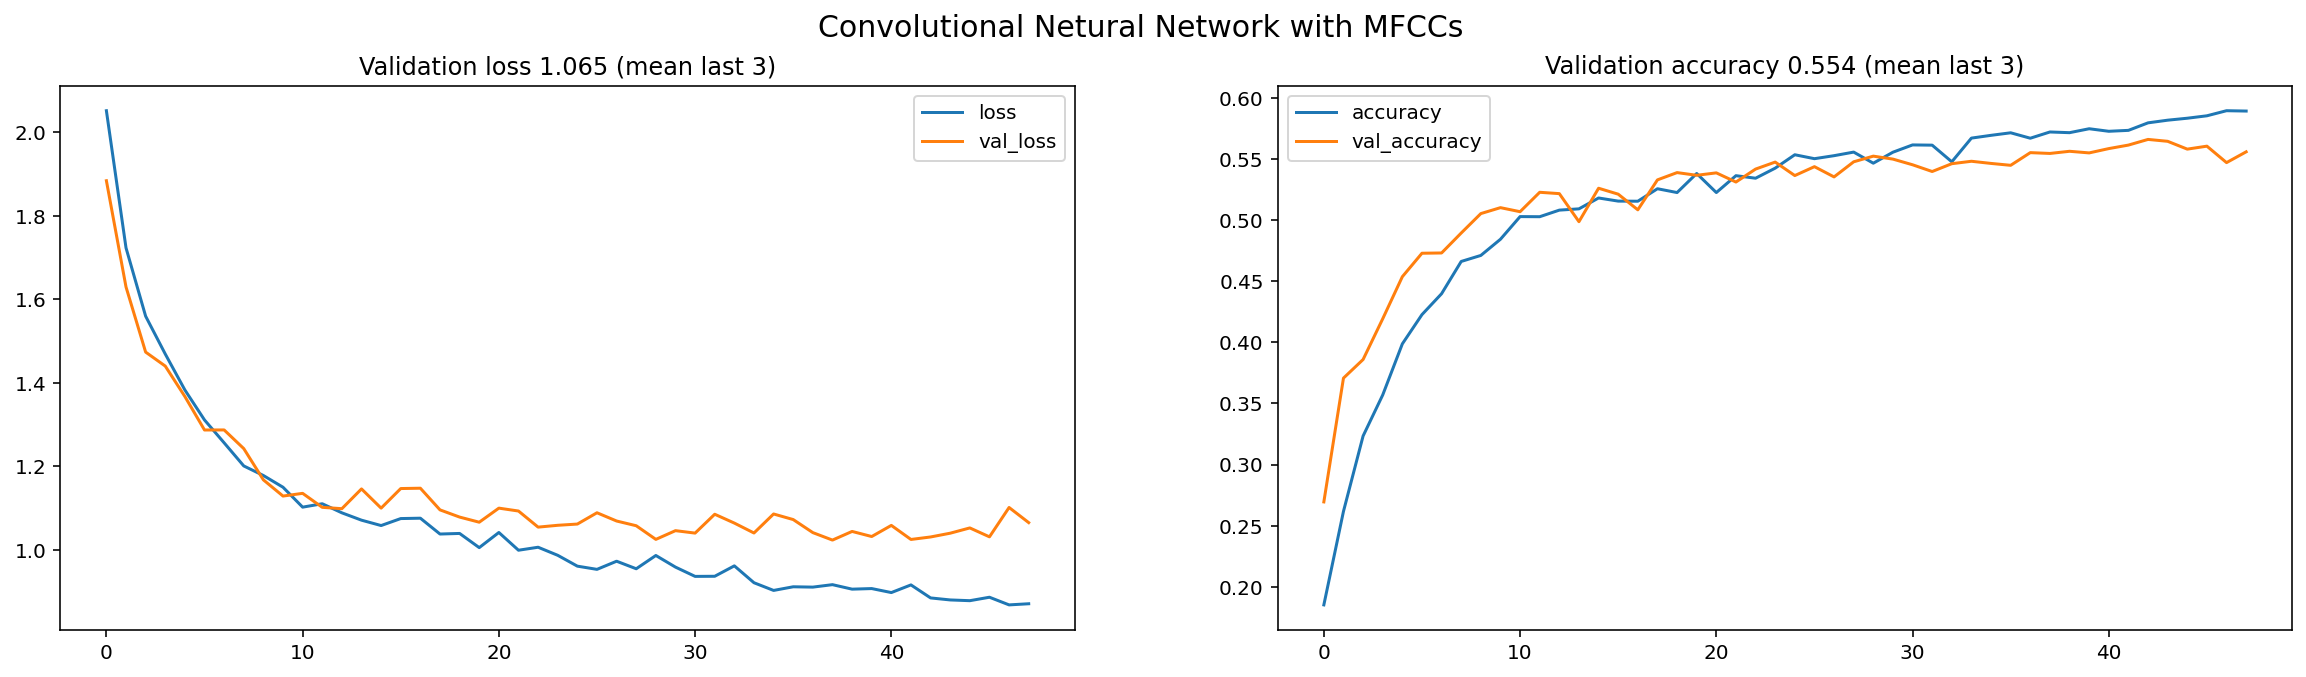

In [25]:
# Plots neural network performance metrics for train and validation
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
plt.suptitle('Convolutional Netural Network with MFCCs', size=15)
results = pd.DataFrame(history.history)
results[["loss", "val_loss"]].plot(ax=axs[0])
axs[0].set_title("Validation loss {:.3f} (mean last 3)".format(np.mean(history.history["val_loss"][-3:])))
results[["accuracy", "val_accuracy"]].plot(ax=axs[1])
axs[1].set_title("Validation accuracy {:.3f} (mean last 3)".format(np.mean(history.history["val_accuracy"][-3:])))
plt.savefig("/content/drive/MyDrive/LY Project/cnn_three_layers_training_curves.png")
plt.show()

In [26]:
# Collect loss and accuracy for the test set
loss_te, accuracy_te = model.evaluate(x_te, y_te)

print("Test loss: {:.2f}".format(loss_te))
print("Test accuracy: {:.2f}%".format(100 * accuracy_te))

53/53 [==============================] - 1s 10ms/step - loss: 1.0002 - accuracy: 0.5563
Test loss: 1.00
Test accuracy: 55.63%


53/53 [==============================] - 0s 5ms/step


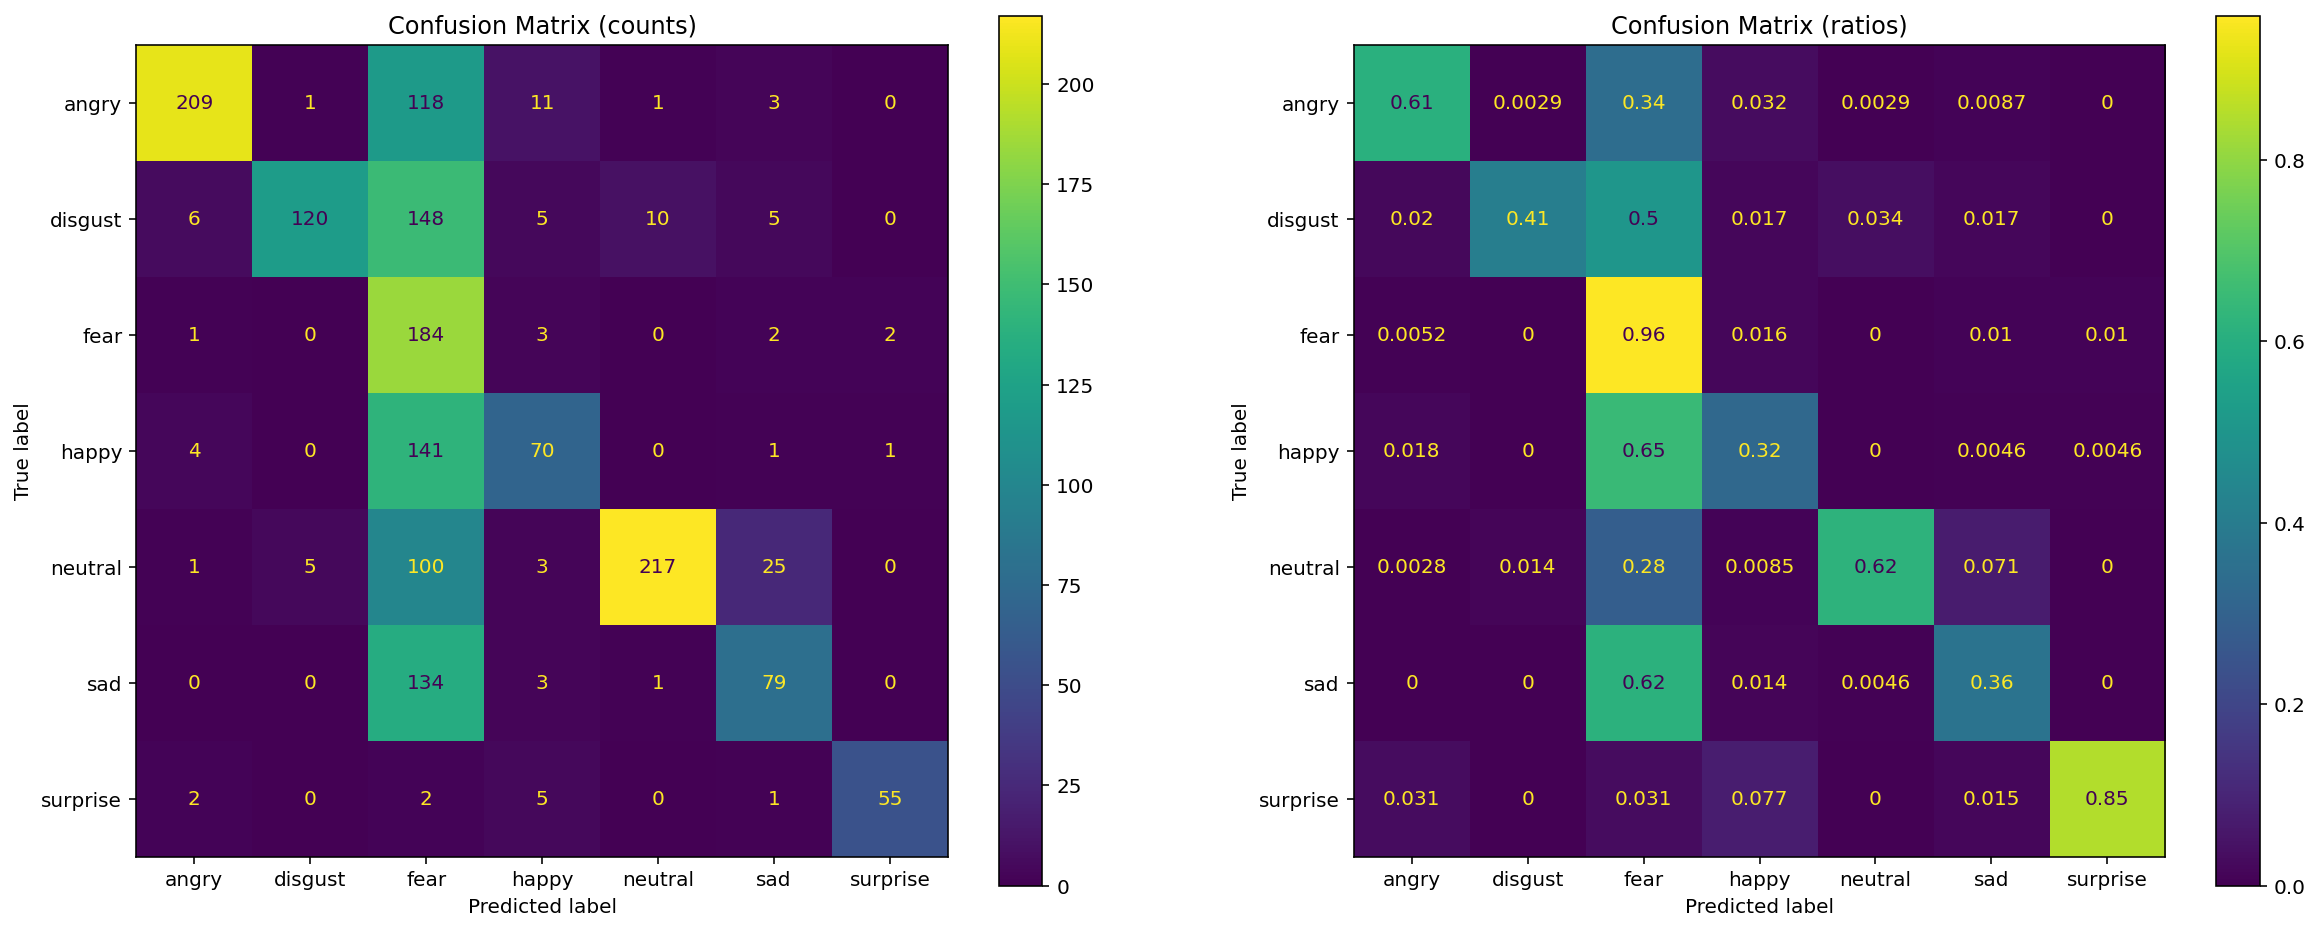

In [27]:
# Compute test set predictions
predictions = model.predict(x_te)

pred = []

for i in predictions:
    pred.append(np.argmax(i))
    
from sklearn.metrics import ConfusionMatrixDisplay

labels = {'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}

def plot_confusion_matrices(y_true, y_pred):

    # Create two subplots
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plots the standard confusion matrix
    ax1.set_title("Confusion Matrix (counts)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, ax=ax1)

    # Plots the normalized confusion matrix
    ax2.set_title("Confusion Matrix (ratios)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, normalize="true", ax=ax2)
    plt.savefig("/content/drive/MyDrive/LY Project/cnn_three_layers_confusion_matrices.png")
    plt.show()

# Plot confusion matrices
plot_confusion_matrices(y_te, pred)